# Multitask Models

Testa modelos de multitasking

## Configuração de Ambiente

In [11]:
# Variáveis de Configuração

# Caminhos de arquivo
raw_data_path = '../data/raw-data/'                 # dados não processados
raw_dataset_path = raw_data_path + 'train_updated.csv'
processed_data_path = '../data/processed-data/'     # dados processados
processed_dataset_path = processed_data_path + 'train.pkl' 
model_path = '../models/trained-models/'

In [12]:
# Imports

# Data manipulation
import pandas as pd
import numpy as np

import pickle as pkl

from joblib import Parallel, delayed

from models import *

# disable warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [13]:
# Variáveis/Constantes Globais
TARGET_COLS = ['target1', 'target2', 'target3', 'target4']

RANDOM_SEED = 42

TEST_SPLIT_DATE = '2021-04-30'

In [14]:
# Carregando o dataframe
df_train = pd.read_pickle(processed_dataset_path)
df_train.head()

,Dt,IdPlayer,target1,target2,target3,target4,IdDtPlayer,target1_shift_1,target2_shift_1,target3_shift_1,...,CdGameState_Final,CdDoubleHeader_N,CdDoubleHeader_S,CdDoubleHeader_Y,CdDayNight_day,CdDayNight_night,FlgWinnerHomeTeam_False,FlgWinnerHomeTeam_True,FlgWinnerAwayTeam_False,FlgWinnerAwayTeam_True
0,2018-01-08,112526,0.032349,4.394531,0.039185,17.625000,2018-01-08 00:00:00_112526,0.014557,4.714844,0.026337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-09,112526,0.016098,1.791016,0.055420,4.628906,2018-01-09 00:00:00_112526,0.032349,4.394531,0.039185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-10,112526,0.075623,1.867188,0.023239,8.507812,2018-01-10 00:00:00_112526,0.016098,1.791016,0.055420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-11,112526,0.035004,2.285156,0.020096,7.941406,2018-01-11 00:00:00_112526,0.075623,1.867188,0.023239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-12,112526,0.018204,0.624023,0.007935,4.925781,2018-01-12 00:00:00_112526,0.035004,2.285156,0.020096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preparação dos Dados

Manter no notebook apenas a preparação pontual dos dados para a aplicação em modelos, toda preparação permanente deve ser adicionada em `/src/data-engineering/data-engineering.ipynb` e então salvo o dataset processado em `/src/data/processed-data/`.

### Funções Auxiliares

Apenas manter aqui funções que serão utilizadas pontualmente no notebook, em caso de funções que serão usadas em outros notebooks, deve-se transferir as mesmas para um arquivo `.py` separado e importar as funções para o notebook.

In [15]:
# Funções Auxiliares

# Imports
from data_preparation import *

# Funções Auxiliares


### Preparação

In [16]:
#Arruma float16 para conseguir rodar baselines
df_train[TARGET_COLS] = df_train[TARGET_COLS].astype('float', copy = True)

In [17]:
df_train = df_train.drop([col for col in df_train.columns if df_train[col].dtype == 'object'], axis=1)
df_train = df_train.drop(['DtGame','IdTeam_x', 'IdTeam_y', 'IdGame'], axis=1)

### Train Test Split

In [18]:
train, test, val = train_test_split(df_train)

In [19]:
train['Dt'] = pd.to_numeric(pd.to_datetime(train['Dt']))
test['Dt']= pd.to_numeric(pd.to_datetime(test['Dt']))
val['Dt'] = pd.to_numeric(pd.to_datetime(val['Dt']))

## Treinando Modelos

In [20]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.multioutput import MultiOutputRegressor

df_results = pd.DataFrame(columns = ['model', 'target1', 'target2', 'target3', 'target4', 'average'])
df_results_amae = pd.DataFrame(columns = ['model', 'target1', 'target2', 'target3', 'target4', 'average'])

### Baselines

In [21]:
# naive
naive = train[train['Dt']=='2021-04-30'].set_index('IdPlayer')[TARGET_COLS]

# media
media = train[TARGET_COLS].mean()
media_por_jogador = train.groupby('IdPlayer')[TARGET_COLS].mean()

# mediana
mediana = train[TARGET_COLS].median()
mediana_por_jogador = train.groupby('IdPlayer')[TARGET_COLS].median()

In [22]:
%%time
summary = pd.DataFrame()

for target in TARGET_COLS:
    
    y_true = test[target]
   
    mediapj_pred = test['IdPlayer'].map(media_por_jogador[target].to_dict())
    medianapj_pred = test['IdPlayer'].map(mediana_por_jogador[target].to_dict())
    naive_pred = test['IdPlayer'].map(naive[target].to_dict())
  
    mediana_pred = [mediana[target] for i in test.index]
    media_pred = [media[target] for i in test.index]
    

    summary.loc['Média',target]  = mean_absolute_error(y_true,media_pred)
    summary.loc['Média por Jogador',target]  = mean_absolute_error(y_true,mediapj_pred)
    summary.loc['Mediana',target]  = mean_absolute_error(y_true,mediana_pred)
    summary.loc['Mediana por Jogador',target]  = mean_absolute_error(y_true,medianapj_pred)
    #summary.loc['Naive',target]  = mean_absolute_error(y_true,naive_pred)
    
summary['average'] = summary.mean(axis=1)
summary = summary.reset_index()
summary = summary.rename(columns = {"index": "model"})
df_results = df_results.append(summary, ignore_index = True)
df_results

CPU times: total: 3.16 s
Wall time: 4.73 s


,model,target1,target2,target3,target4,average
0,Média,1.154659,2.733154,1.081328,1.458545,1.606922
1,Média por Jogador,0.975862,2.281572,0.974669,1.033312,1.316354
2,Mediana,0.744365,1.667283,0.512541,1.149322,1.018378
3,Mediana por Jogador,0.734746,1.601819,0.508404,0.936245,0.945304


In [23]:
%%time
summary = pd.DataFrame()
for target in TARGET_COLS:
    
    y_true = test[target]
    
    mediapj_pred = test['IdPlayer'].map(media_por_jogador[target].to_dict())
    medianapj_pred = test['IdPlayer'].map(mediana_por_jogador[target].to_dict())
    naive_pred = test['IdPlayer'].map(naive[target].to_dict())
    
    mediana_pred = [mediana[target] for i in test.index]
    media_pred = [media[target] for i in test.index]
    
    
    summary.loc['Média',target]  =  AMAE(y_true,media_pred,show = False)
    summary.loc['Média por Jogador',target]  =  AMAE(y_true,mediapj_pred,show = False)
    summary.loc['Mediana',target]  =  AMAE(y_true,mediana_pred,show = False)
    summary.loc['Mediana por Jogador',target]  =  AMAE(y_true,medianapj_pred,show = False)
    #summary.loc['Naive',target]  =  AMAE(y_true,naive_pred,show = False)
    
summary['average'] = summary.mean(axis=1)
summary = summary.reset_index()
summary = summary.rename(columns = {"index": "model"})

CPU times: total: 1min 16s
Wall time: 2min 1s


In [24]:
df_results_amae = df_results_amae.append(summary, ignore_index = True)
df_results_amae

,model,target1,target2,target3,target4,average
0,Média,6843.978819,6398.583724,7121.952787,6823.816072,6797.082850
1,Média por Jogador,6414.161377,5524.151229,6761.462720,6119.308259,6204.770897
2,Mediana,6900.775560,6587.051921,7190.445719,6912.163273,6897.609118
3,Mediana por Jogador,6833.931392,6005.371015,7149.410960,6419.212379,6601.981437


### Modelos Lineares

#### LASSO

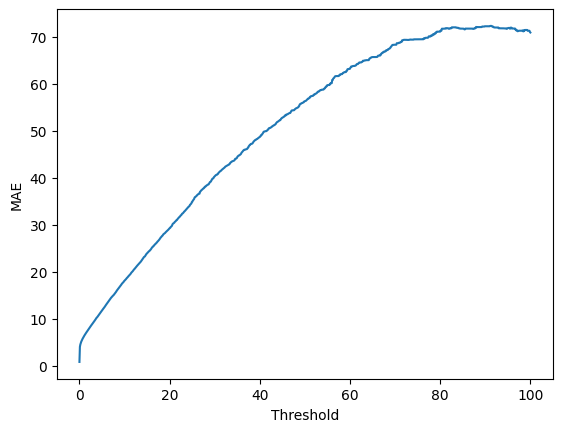

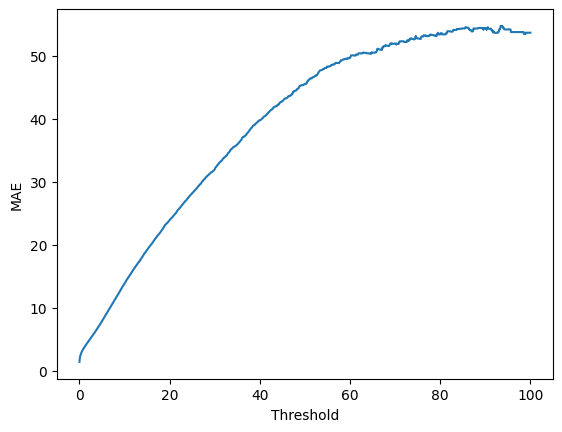

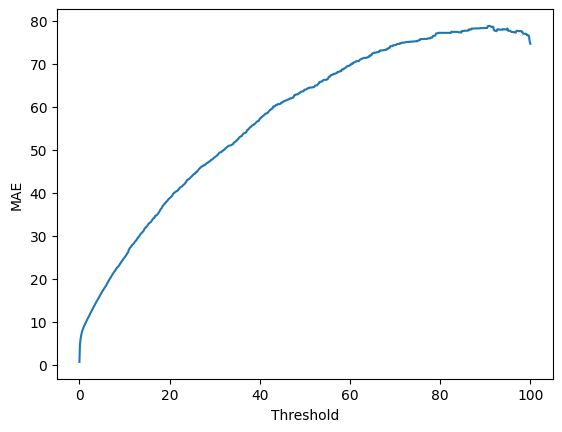

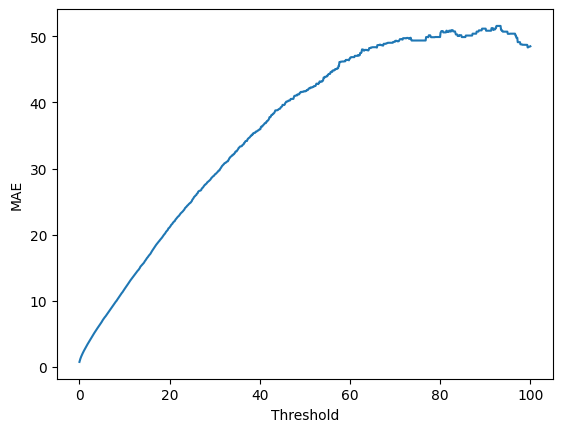

CPU times: total: 24min 3s
Wall time: 9min 5s


,model,target1,target2,target3,target4,average
4,Lasso | MultiOutput,0.813829,1.378054,0.723575,0.751926,0.916846
5,Lasso | MultiOutput,5063.447197,3935.638273,5762.797741,3632.457923,4598.585283


In [15]:
%%time
from sklearn.linear_model import Lasso

# defines the model and create the multioutput regressor
model = Lasso(alpha=0.1, random_state=RANDOM_SEED)
model_name = 'Lasso | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)

# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)

# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]

df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

#### Ridge

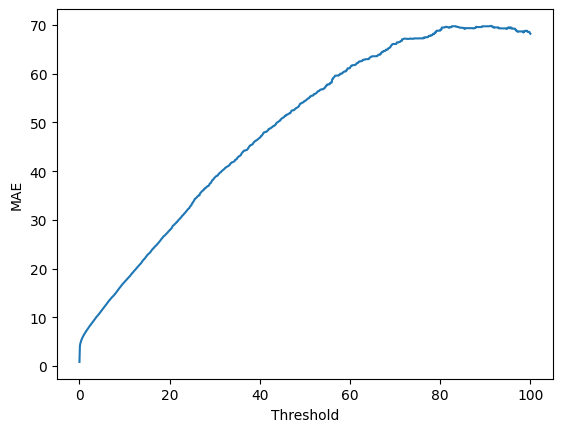

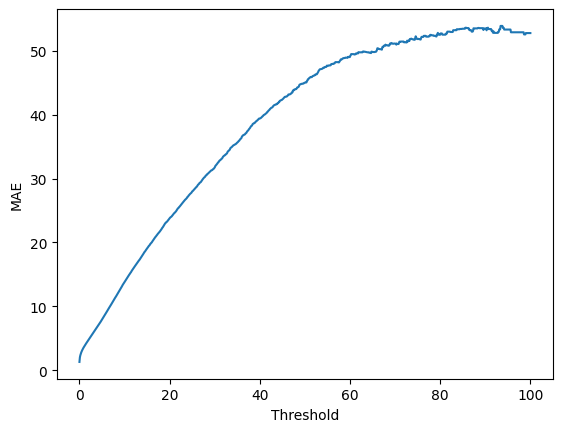

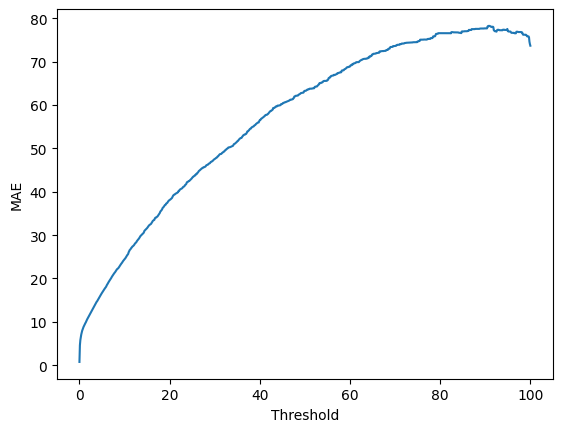

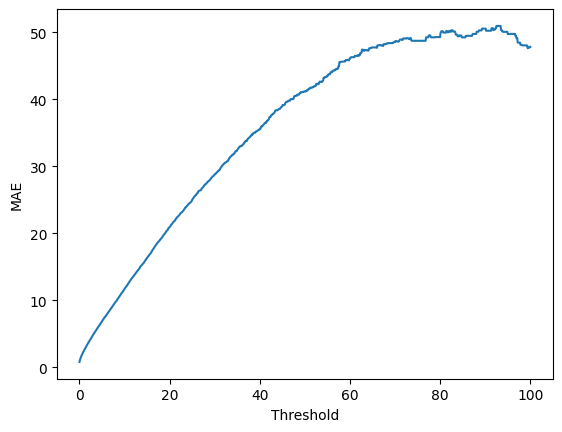

CPU times: total: 1min 5s
Wall time: 58.9 s


,model,target1,target2,target3,target4,average
4,Ridge | MultiOutput,0.825701,1.288335,0.756863,0.777672,0.912143
5,Ridge | MultiOutput,4887.688917,3889.218251,5695.880423,3590.584840,4515.843108


In [25]:
%%time
from sklearn.linear_model import Ridge

# defines the model and create the multioutput regressor
model = Ridge(alpha=0.1, random_state=RANDOM_SEED)
model_name = 'Ridge | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)

# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]


df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

#### ElasticNet

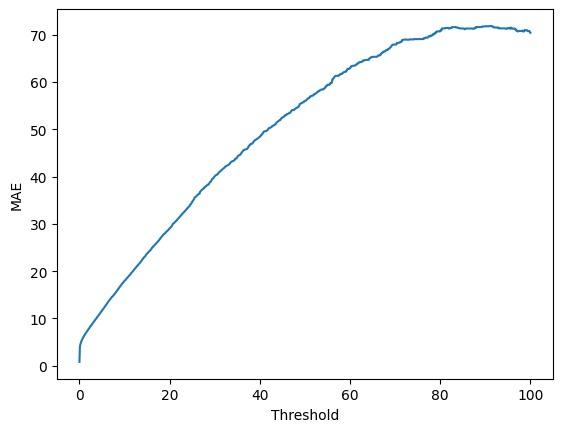

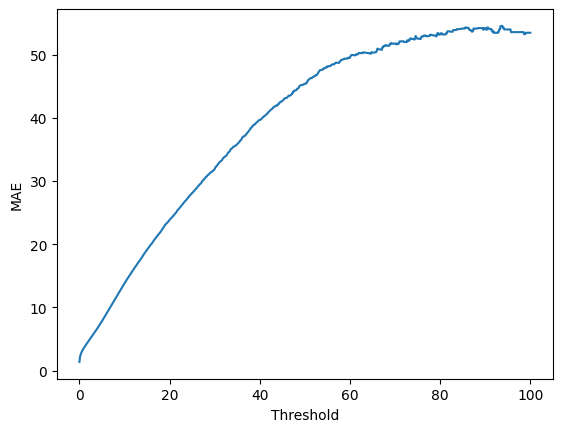

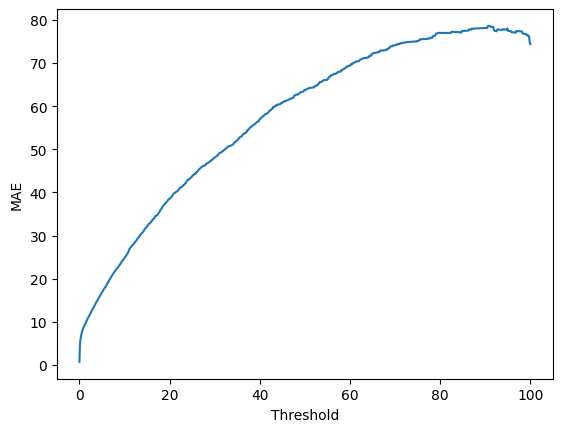

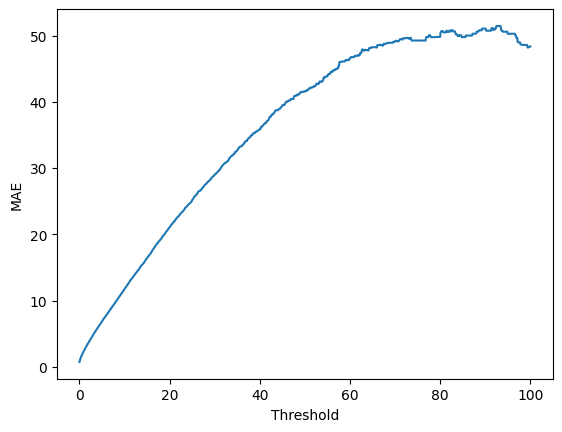

CPU times: total: 1h 24min 41s
Wall time: 30min 18s


,model,target1,target2,target3,target4,average
7,ElasticNet | MultiOutput,0.816619,1.368344,0.725792,0.753823,0.916144
8,ElasticNet | MultiOutput,5031.979021,3925.764941,5741.544073,3624.663597,4580.987908


In [18]:
%%time
from sklearn.linear_model import ElasticNet

# defines the model and create the multioutput regressor
model = ElasticNet(alpha=0.1, random_state=RANDOM_SEED)
model_name = 'ElasticNet | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)


# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]


df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

### Tree Models

In [19]:
%%time
from sklearn.tree import DecisionTreeRegressor

# defines the model and create the multioutput regressor
model = DecisionTreeRegressor(random_state=RANDOM_SEED)
model_name = 'DecisionTreeRegressor | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)


# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]


df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

#### Gradient Boosting

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

# defines the model and create the multioutput regressor
model = GradientBoostingRegressor(random_state=RANDOM_SEED)
model_name = 'GradientBoostingRegressor | MultiOutput'
regressor = MultiOutputRegressor(model)

# fit the model
regressor.fit(train.drop(columns=TARGET_COLS), train[TARGET_COLS])

# make predictions
y_pred = pd.DataFrame(regressor.predict(test.drop(columns=TARGET_COLS)), columns=TARGET_COLS)


# evaluate the model
mae = evaluate_mae(test[TARGET_COLS], y_pred)
amae = evaluate_amae(test[TARGET_COLS], y_pred)
# save the results
df_results = df_results.append({'model': model_name, **mae}, ignore_index=True)
df_results[df_results['model'] == model_name]


df_results_amae = df_results.append({'model': model_name, **amae}, ignore_index=True)
df_results_amae[df_results_amae['model'] == model_name]

## Resultados

In [ ]:
df_results

,model,target1,target2,target3,target4,average
0,Lasso | MultiOutput,0.786738,1.367479,0.706509,0.745432,0.901539
1,Ridge | MultiOutput,0.789278,1.292713,0.737686,0.760436,0.895028
2,ElasticNet | MultiOutput,0.789226,1.364733,0.713458,0.747147,0.903641
3,DecisionTreeRegressor | MultiOutput,2.109487,2.260997,1.739849,1.628264,1.934649


In [ ]:
df_results_amae